# Q-Learning

In [1]:
from dataclasses import dataclass
from typing import Optional, Union, List
import numpy as np
import gym
import gym.spaces
import gym.envs.registration
from gym.utils import seeding
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
from PIL import Image, ImageDraw
import plotly.express as px

import utilsd3 as utils
from solutionsd2 import *

MAIN = __name__ == "__main__"

In [2]:
ObsType = int
ActType = int

class DiscreteEnviroGym(gym.Env):
    action_space: gym.spaces.Discrete
    observation_space: gym.spaces.Discrete

    def __init__(self, env: Environment):
        super().__init__()
        self.env = env
        self.observation_space = gym.spaces.Discrete(env.num_states)
        self.action_space = gym.spaces.Discrete(env.num_actions)
        self.reset()

    def step(self, action: ActType) -> tuple[ObsType, float, bool, dict]:
        '''
        Samples from the underlying dynamics of the environment
        '''
        (states, rewards, probs) = self.env.dynamics(self.pos, action)
        idx = self.np_random.choice(len(states), p=probs)
        (new_state, reward) = (states[idx], rewards[idx])
        self.pos = new_state
        done = self.pos in self.env.terminal
        return (new_state, reward, done, {"env": self.env})

    def reset(
        self, seed: Optional[int] = None, return_info=False, options=None
    ) -> Union[ObsType, tuple[ObsType, dict]]:
        super().reset(seed=seed)
        self.pos = self.env.start
        return (self.pos, {"env": self.env}) if return_info else self.pos

    def render(self, mode="human"):
        assert mode == "human", f"Mode {mode} not supported!"

In [3]:
gym.envs.registration.register(
    id="NorvigGrid-v0",
    entry_point=DiscreteEnviroGym,
    max_episode_steps=100,
    nondeterministic=True,
    kwargs={"env": Norvig(penalty=-0.04)},
)

gym.envs.registration.register(
    id="ToyGym-v0", 
    entry_point=DiscreteEnviroGym, 
    max_episode_steps=2, 
    nondeterministic=False, 
    kwargs={"env": Toy()}
)

In [4]:
@dataclass
class Experience:
    '''A class for storing one piece of experience during an episode run'''
    obs: ObsType
    act: ActType
    reward: float
    new_obs: ObsType
    new_act: Optional[ActType] = None

@dataclass
class AgentConfig:
    '''Hyperparameters for agents'''
    epsilon: float = 0.1
    lr: float = 0.05
    optimism: float = 0

defaultConfig = AgentConfig()

class Agent:
    '''Base class for agents interacting with an environment (you do not need to add any implementation here)'''
    rng: np.random.Generator

    def __init__(self, env: DiscreteEnviroGym, config: AgentConfig = defaultConfig, gamma: float = 0.99, seed: int = 0):
        self.env = env
        self.reset(seed)
        self.config = config
        self.gamma = gamma
        self.num_actions = env.action_space.n
        self.num_states = env.observation_space.n
        self.name = type(self).__name__

    def get_action(self, obs: ObsType) -> ActType:
        raise NotImplementedError()

    def observe(self, exp: Experience) -> None:
        '''
        Agent observes experience, and updates model as appropriate.
        Implementation depends on type of agent.
        '''
        pass

    def reset(self, seed: int) -> None:
        self.rng = np.random.default_rng(seed)

    def run_episode(self, seed) -> List[int]:
        '''
        Simulates one episode of interaction, agent learns as appropriate
        Inputs:
            seed : Seed for the random number generator
        Outputs:
            The rewards obtained during the episode
        '''
        rewards = []
        obs = self.env.reset(seed=seed)
        self.reset(seed=seed)
        done = False
        while not done:
            act = self.get_action(obs)
            (new_obs, reward, done, info) = self.env.step(act)
            exp = Experience(obs, act, reward, new_obs)
            self.observe(exp)
            rewards.append(reward)
            obs = new_obs
        return rewards

    def train(self, n_runs=500):
        '''
        Run a batch of episodes, and return the total reward obtained per episode
        Inputs:
            n_runs : The number of episodes to simulate
        Outputs:
            The discounted sum of rewards obtained for each episode
        '''
        all_rewards = []
        for seed in trange(n_runs):
            rewards = self.run_episode(seed)
            all_rewards.append(utils.sum_rewards(rewards, self.gamma))
        return all_rewards

class Random(Agent):
    def get_action(self, obs: ObsType) -> ActType:
        return self.rng.integers(0, self.num_actions)

In [5]:
# pulled from w6d2 - used to help calculate perfectly optimal policy given information agents shouldn't have access to
class CheatFunctions():
        def policy_eval_exact(self, env: Environment, pi: Arr, gamma=0.99) -> Arr:
            p_pi = np.zeros((env.num_states, env.num_states))
            R_pi = np.zeros((env.num_states, env.num_states))
            for x in range(env.num_states):
                for y in range(env.num_states):
                    p_pi[x,y] = env.T[x,pi[x],y]   
                    R_pi[x,y] = env.R[x, pi[x], y] 
            


            r_pi = np.zeros(env.num_states)
            for state in range(env.num_states):
                value = 0
                for jstate in range(env.num_states):
                    value += p_pi[state, jstate] * R_pi[state, jstate]
                r_pi[state] = value


            I = np.identity(env.num_states)


            return np.linalg.inv(I - gamma * p_pi).dot(r_pi)
        
        def find_optimal_policy(self, env: Environment, gamma=0.99):
            '''
            Inputs:
                env: environment
            Outputs:
                pi : (num_states,) int, of actions represeting an optimal policy
            '''
            pi = np.zeros(env.num_states, dtype=int)
            while True:
                valueFunc = policy_eval_exact(env, pi, gamma)
                newpi = policy_improvement(env, valueFunc, gamma)

                if (np.array_equal(pi, newpi)):
                    break
                else:
                    pi = newpi.copy()
            return pi
        
        def policy_improvement(self, env: Environment, V: Arr, gamma=0.99) -> Arr:
            '''
            Inputs:
                env: Environment
                V  : (num_states,) value of each state following some policy pi
            Outputs:
                pi_better : vector (num_states,) of actions representing a new policy obtained via policy iteration
            '''
            pi_better = np.zeros(env.num_states, dtype=int)
            
            for eval_state in range(env.num_states):
                action_highest = 0
                action_highest_sum = None

                for action in range(env.num_actions):
                    sum = 0
                    for s_prime in range(env.num_states):
                        sum += env.T[eval_state, action, s_prime] * (env.R[eval_state, action, s_prime] + gamma * V[s_prime])
                    
                    if action_highest_sum == None or sum > action_highest_sum:
                        action_highest = action
                        action_highest_sum = sum

                pi_better[eval_state] = action_highest


            return pi_better

100%|██████████| 100/100 [00:00<00:00, 14373.90it/s]


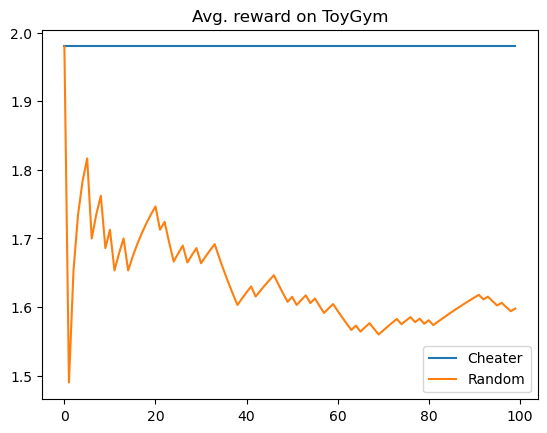

In [6]:
class Cheater(Agent):
    def __init__(self, env: DiscreteEnviroGym, config: AgentConfig = defaultConfig, gamma=0.99, seed=0):
        super().__init__(env, config, gamma, seed)
        cFuncs = CheatFunctions()
        self.actions = cFuncs.find_optimal_policy(env.unwrapped.env, gamma)
        
        
        

    def get_action(self, obs):
        return self.actions[obs]


if MAIN:
    env_toy = gym.make("ToyGym-v0")
    agents_toy = [Cheater(env_toy), Random(env_toy)]
    for agent in agents_toy:
        returns = agent.train(n_runs=100)
        plt.plot(utils.cummean(returns), label=agent.name)
    plt.legend()
    plt.title(f"Avg. reward on {env_toy.spec.name}")
    plt.show()

## SARSA learning
Perhaps the most elegantly name thing in the entire world of Artificial Intelligence. I love it.

Simply, it stands for state action reward state action, which is what is needed to perform an update on your Q-value function. Beautiful.

SARSA is an on-policy learning algorithm, meaning that it updates the action-value function for the current policy.

In [7]:
class EpsilonGreedy(Agent):
    '''
    A class for SARSA and Q-Learning to inherit from.
    '''

    def __init__(self, env: DiscreteEnviroGym, config: AgentConfig = defaultConfig, gamma: float = 0.99, seed: int = 0):
        super().__init__(env, config, gamma, seed)
        self.Q = config.optimism * np.ones((self.num_states, self.num_actions)) # array of shape (states, actions)
        self.epsilon = config.epsilon
        self.num_actions = self.num_actions
        

    def get_action(self, obs: ObsType) -> ActType:
        '''
        Selects an action using epsilon-greedy with respect to Q-value estimates
        '''
        if self.rng.random() < self.epsilon:
            return self.rng.integers(0, self.num_actions)
        else:
            return self.Q.argmax(axis = 1)[obs]

class QLearning(EpsilonGreedy):
    def observe(self, exp: Experience) -> None:
        '''
        Agent observes experience, and updates model as appropriate.
        Implementation depends on type of agent.
        '''
        optimalQ = self.Q.max(axis = 1)[exp.new_obs]
        TDError = exp.reward + self.gamma * optimalQ - self.Q[exp.obs, exp.act]
        self.Q[exp.obs, exp.act] += self.epsilon * (TDError)

class SARSA(EpsilonGreedy):
    def observe(self, exp: Experience) -> None:
        '''
        Agent observes experience, and updates model as appropriate.
        Implementation depends on type of agent.
        '''

        TDError = exp.reward + self.gamma * self.Q[exp.new_obs, self.get_action(exp.obs)] - self.Q[exp.obs, exp.act]
        self.Q[exp.obs, exp.act] += self.epsilon * (TDError)

100%|██████████| 1000/1000 [00:00<00:00, 3213.26it/s]


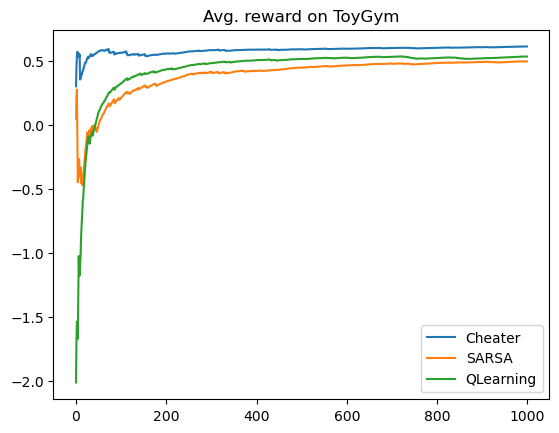

In [8]:
if MAIN:
    env_norvig = gym.make("NorvigGrid-v0")
    config_norvig = AgentConfig(0.12, 0.1, 2) # somewhat finetuned - may be overfitted
    n_runs = 1000
    gamma = 0.99
    seed = 1
    args_nor = (env_norvig, config_norvig, gamma, seed)
    agents_norvig = [Cheater(*args_nor), SARSA(*args_nor), QLearning(*args_nor)] # [Cheater(*args_nor), QLearning(*args_nor), SARSA(*args_nor), Random(*args_nor)]
    returns_norvig = {}
    for agent in agents_norvig:
        returns_norvig[agent.name] = agent.train(n_runs)
if MAIN:
    for agent in agents_norvig:
        name = agent.name
        plt.plot(utils.cummean(returns_norvig[name]), label=name)
    plt.legend()
    plt.title(f"Avg. reward on {env_toy.spec.name}")
    plt.show()

# Trying it on a new environment

100%|██████████| 1000/1000 [00:00<00:00, 4692.57it/s]
/Users/codyrushing/mambaforge/envs/ARENAenv/lib/python3.9/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



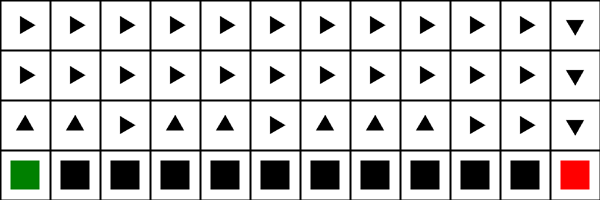

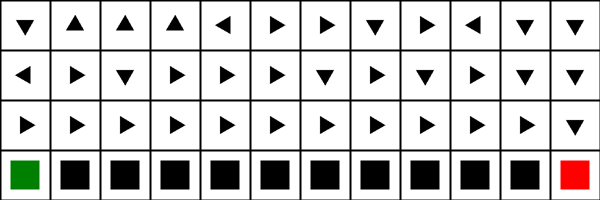

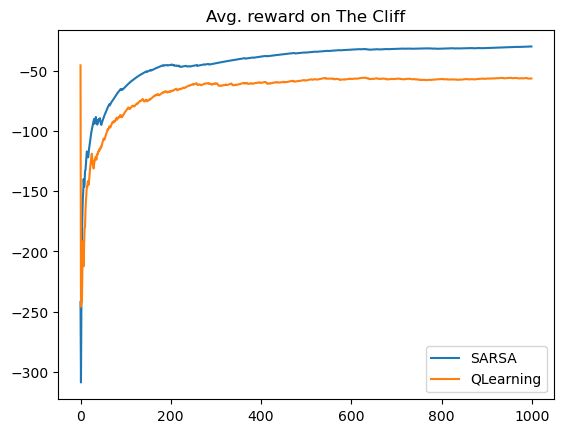

In [9]:
def show_cliff_value(Q: Arr, title: Optional[str] = None):
    '''
    Displays the value of each state in CliffWalking-v0 given a Q-value table.
    '''
    V = Q.max(axis=-1).reshape(4, 12)
    fig = px.imshow(V, text_auto=".2f", title=title)
    fig.show()

def show_cliff_policy(Q: Arr):
    '''
    Displays the greedy policy for CliffWalking-v0 given a Q-value table.
    '''
    pi = Q.argmax(axis=-1).reshape((4, 12))
    objects = {(3, 0): "green", (3, 11): "red"} | {(3, i): "black" for i in range(1, 11)}
    img = Image.new(mode="RGB", size=(1200, 400), color="white")
    draw = ImageDraw.Draw(img)
    for x in range(0, img.width+1, 100):
        draw.line([(x, 0), (x, img.height)], fill="black", width=4)
    for y in range(0, img.height+1, 100):
        draw.line([(0, y), (img.width, y)], fill="black", width=4)
    for x in range(12):
        for y in range(4):
            draw.regular_polygon((50+x*100, 50+y*100, 20), 3, rotation=-int(90*pi[y][x]), fill="black")
            if (y, x) in objects:
                draw.regular_polygon((50+x*100, 50+y*100, 40), 4, fill=objects[(y, x)])
    display(img.resize((600, 200)))


if MAIN:
    cliffwalker = gym.make("CliffWalking-v0")
    config_cliff = AgentConfig(0.12, 0.1, 2) # somewhat finetuned - may be overfitted
    n_runs = 1000
    gamma = 0.99
    seed = 1
    args_cliff = (cliffwalker, config_cliff, gamma, seed)
    agents_cliff = [SARSA(*args_cliff), QLearning(*args_cliff)] # [Cheater(*args_nor), QLearning(*args_nor), SARSA(*args_nor), Random(*args_nor)]
    returns_cliff = {}
    for agent in agents_cliff:
        returns_cliff[agent.name] = agent.train(n_runs)

if MAIN:
    for agent in agents_cliff:
        name = agent.name
        show_cliff_value(agent.Q)
        show_cliff_policy(agent.Q)
        plt.plot(utils.cummean(returns_cliff[name]), label=name)
    plt.legend()
    plt.title(f"Avg. reward on The Cliff")
    plt.show()

